### Imports and Definitions

In [1]:
from glob import glob
from math import log10
from matplotlib import rcParams
from matplotlib.lines import Line2D
from os import makedirs
from seaborn import pointplot, set_context, set_style, violinplot
from zipfile import ZipFile
import matplotlib.pyplot as plt
ZERO_THRESH = 0.0000000001
DATADIR = '../data'
FIGDIR = '../figs'; makedirs(FIGDIR, exist_ok=True)
RC = {"font.size":12,"axes.titlesize":16,"axes.labelsize":14,"legend.fontsize":10,"xtick.labelsize":10,"ytick.labelsize":10}
set_context("paper", rc=RC); set_style("ticks"); rcParams['font.family'] = 'serif'
rcParams['patch.edgecolor'] = '4C4C4C' # set boxenplot outlines same as violinplot
meta = {
    'time_fn': {
        'SEQTK':                      'time.01.seqtk.subsample.txt',
        'MINIMAP2':                   'time.02.minimap2.txt',
        'SAMTOOLS_SORT_UNTRIMMED':    'time.03.samtools.sort.untrimmed.txt',
        'IVAR_TRIM':                  'time.04.ivar.trim.txt',
        'SAMTOOLS_SORT_IVAR_TRIMMED': 'time.05.samtools.sort.ivar.trimmed.txt',
        'SAMTOOLS_PILEUP':            'time.06.samtools.pileup.txt',
        'IVAR_VARIANTS':              'time.07.ivar.variants.txt',
        'IVAR_CONSENSUS':             'time.08.ivar.consensus.txt',
        'AMPLIPY_TRIM':               'time.09.amplipy.trim.txt',
        'AMPLIPY_VARIANTS':           'time.10.amplipy.variants.txt',
        'AMPLIPY_CONSENSUS':          'time.11.amplipy.consensus.txt',
        'AMPLIPY_AIO':                'time.12.amplipy.aio.txt',
    },
    
    
    'label': {
        'amplipy_aio': 'AmpliPy (AIO)',
        'ivar_pipeline': 'iVar (Pipeline)',
        'time': 'Total Runtime (s)',
        'mem': 'Peak Memory (MB)',
        'ratio_time': 'iVar/AmpliPy Runtime Ratio',
        'ratio_mem': 'iVar/AmpliPy Peak Memory Ratio',
    },
    
    'color': {
        'amplipy_aio': 'green',
        'ivar_pipeline': 'red',
        'ratio': 'black',
    },
    
    'linestyle': {
        'amplipy_aio': '-',
        'ivar_pipeline': '--',
        'ratio': '-',
    },
    
    'steps': {
        'ivar_pipeline': ['SAMTOOLS_SORT_UNTRIMMED', 'IVAR_TRIM', 'SAMTOOLS_SORT_IVAR_TRIMMED', 'SAMTOOLS_PILEUP', 'IVAR_VARIANTS', 'IVAR_CONSENSUS'],
        'amplipy_aio': ['AMPLIPY_AIO'],
        'iVar (Variants + Consensus)': ['SAMTOOLS_SORT_IVAR_TRIMMED', 'SAMTOOLS_PILEUP', 'IVAR_VARIANTS', 'IVAR_CONSENSUS'],
        'AmpliPy (Variants + Consensus)': ['AMPLIPY_VARIANTS', 'AMPLIPY_CONSENSUS'],
    },
    'human_readable_steps': {
        'ivar_pipeline': ['Sorting Untrimmed Reads', 'Trimming Reads', 'Sorting Trimmed Reads', 'Pileup Step', 'Variant Calling', 'Consensus'],
    }
}

### Helper: Convert Power of 10 to Scientific Notation

In [2]:
def sci_not_mult10(n):
    p = log10(n)
    assert abs(p-int(p)) < ZERO_THRESH, "Not a power of 10: %s" % n
    return r'$10^%d$' % p

### Helper: Parse `/usr/bin/time` Output

In [3]:
def parse_time_output(lines):
    t = None; m = None
    for l in lines:
        if l.strip().startswith('Elapsed (wall clock) time (h:mm:ss or m:ss)'):
            parts = l.split()[-1].split(':')
            if len(parts) == 3: # h:mm:ss
                t = float(parts[0])*3600 + float(parts[1])*60 + float(parts[2])
            elif len(parts) == 2: # m:ss
                t = float(parts[0])*60 + float(parts[1])
            else:
                assert False, "Invalid time: %s" % ':'.join(parts)
        elif l.strip().startswith('Maximum resident set size (kbytes)'):
            m = int(l.split()[-1]) / 1024 # store peak memory as MB instead of KB
    assert t is not None, "Failed to parse runtime"
    assert m is not None, "Failed to parse peak memory"
    return t, m

### Load Data from Zips

In [4]:
data = dict()
for z_fn in glob('%s/n*/n*.r*.zip' % DATADIR):
    n = int(z_fn.split('/')[-1].split('.')[0].lstrip('n'))
    r = int(z_fn.split('/')[-1].split('.')[1].lstrip('r'))
    z = ZipFile(z_fn)
    if n not in data:
        data[n] = dict()
    if r not in data[n]:
        data[n][r] = dict()
    for comp_fn in z.namelist():
        if comp_fn.startswith('time.'):
            t, m = parse_time_output(z.read(comp_fn).decode().splitlines())
            data[n][r][comp_fn] = {'time':t, 'mem':m}

# Breaking down time taken for each step in the Pipeline

The following charts break down the time taken and the memory used and show how much each step in the iVar pipeline actually uses. The second set of charts show the same thing, but this time as a proportion of the total time, so that you can see how the time/memory usage evolves as the number of reads increase.

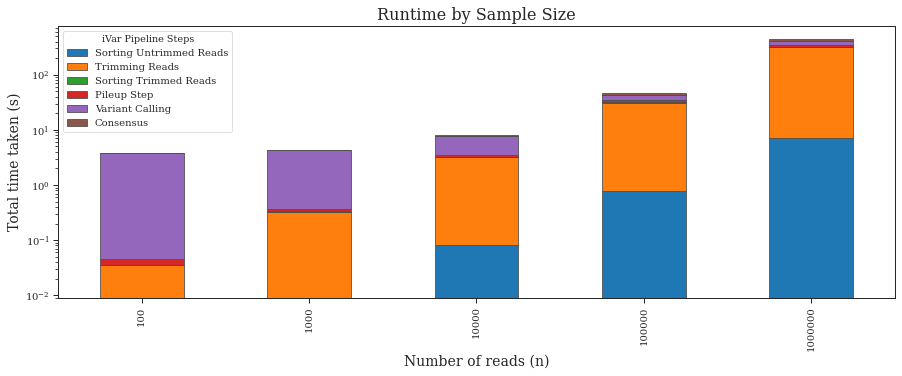

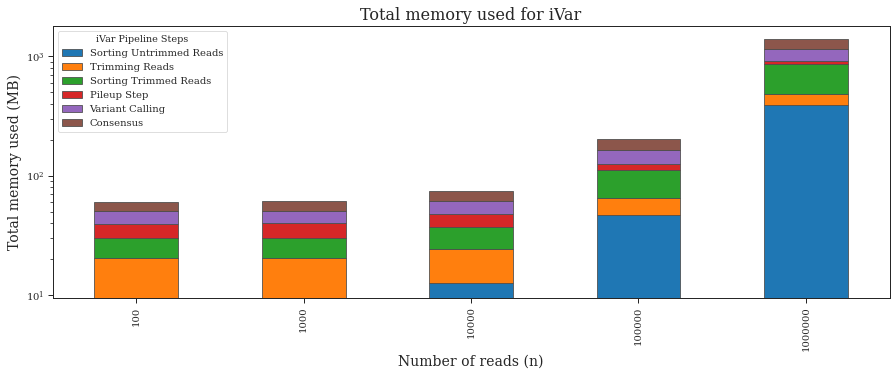

In [34]:
# charts that show total time taken and total memory used
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

labels = [100,1000,10000,100000,1000000]
steps = meta['steps']['ivar_pipeline']
human_readable_steps = meta['human_readable_steps']['ivar_pipeline']


timeTakenData = []
for n in labels:
	timeTakenData.append([str(n)] + [sum([data[n][r][meta['time_fn'][step]]['time'] for r in range(1,10)])/10 for step in steps])

df = pd.DataFrame(timeTakenData,
columns=["Steps"] + human_readable_steps)

time_chart = df.plot(x='Steps', kind='bar', stacked=True,
        title='Runtime by Sample Size', figsize=(15,5))
time_chart.set_ylabel("Total time taken (s)")
time_chart.set_xlabel("Number of reads (n)")
time_chart.set_yscale('log')
time_chart.axes.legend(title="iVar Pipeline Steps")

memoryUsedData = []
for n in labels:
	memoryUsedData.append([str(n)] + [sum([data[n][r][meta['time_fn'][step]]['mem'] for r in range(1,10)])/10 for step in steps])

df = pd.DataFrame(memoryUsedData,
columns=["Steps"] + human_readable_steps)

mem_chart = df.plot(x='Steps', kind='bar', stacked=True,
        title='Total memory used for iVar', figsize=(15,5))
mem_chart.set_ylabel("Total memory used (MB)")
mem_chart.set_xlabel("Number of reads (n)")
mem_chart.set_yscale('log')
mem_chart.axes.legend(title="iVar Pipeline Steps")


# save figures
time_chart.get_figure().savefig('%s/%s.png' % (FIGDIR, 'time_taken'), format='png', bbox_inches='tight')
mem_chart.get_figure().savefig('%s/%s.png' % (FIGDIR, 'mem_used'), format='png', bbox_inches='tight')
time_chart.get_figure().savefig('%s/%s.pdf' % (FIGDIR, 'time_taken'), format='pdf', bbox_inches='tight')
mem_chart.get_figure().savefig('%s/%s.pdf' % (FIGDIR, 'mem_used'), format='pdf', bbox_inches='tight')


     Steps  Sorting Untrimmed Reads  Trimming Reads  Sorting Trimmed Reads  \
0      100                    0.000           0.036                  0.000   
1     1000                    0.009           0.320                  0.009   
2    10000                    0.081           3.099                  0.072   
3   100000                    0.773          30.638                  0.675   
4  1000000                    7.113         310.130                  6.487   

   Pileup Step  Variant Calling  Consensus  
0        0.009            3.715      0.028  
1        0.034            3.947      0.065  
2        0.261            4.106      0.435  
3        2.615            7.869      4.185  
4       30.090           48.895     45.286  


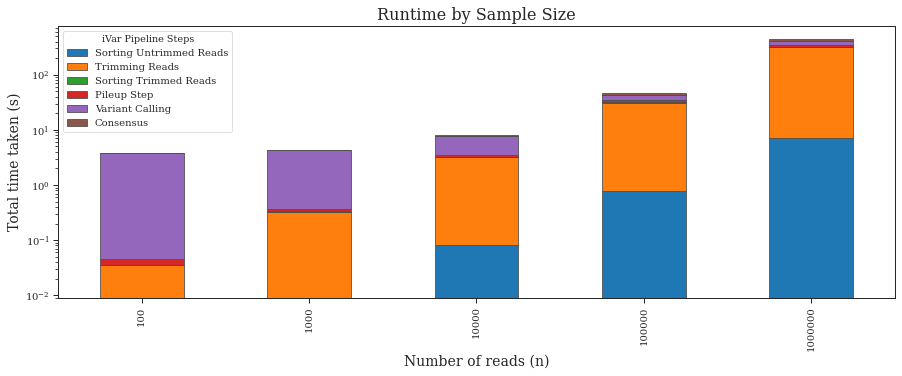

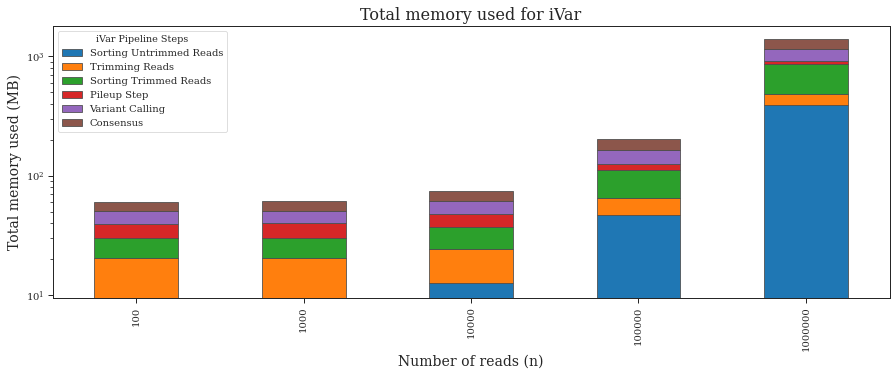

In [49]:
# charts that show total time taken and total memory used
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

labels = [100,1000,10000,100000,1000000]
steps = meta['steps']['ivar_pipeline']
human_readable_steps = meta['human_readable_steps']['ivar_pipeline']


timeTakenData = []
for n in labels:
	timeTakenData.append([str(n)] + [sum([data[n][r][meta['time_fn'][step]]['time'] for r in range(1,10)])/10 for step in steps])

df = pd.DataFrame(timeTakenData,
columns=["Steps"] + human_readable_steps)
print(df)

time_chart = df.plot(x='Steps', kind='bar', stacked=True,
        title='Runtime by Sample Size', figsize=(15,5))
time_chart.set_ylabel("Total time taken (s)")
time_chart.set_xlabel("Number of reads (n)")
time_chart.set_yscale('log')
time_chart.axes.legend(title="iVar Pipeline Steps")

memoryUsedData = []
for n in labels:
	memoryUsedData.append([str(n)] + [sum([data[n][r][meta['time_fn'][step]]['mem'] for r in range(1,10)])/10 for step in steps])

df = pd.DataFrame(memoryUsedData,
columns=["Steps"] + human_readable_steps)

mem_chart = df.plot(x='Steps', kind='bar', stacked=True,
        title='Total memory used for iVar', figsize=(15,5))
mem_chart.set_ylabel("Total memory used (MB)")
mem_chart.set_xlabel("Number of reads (n)")
# mem_chart.set_yscale('log')
mem_chart.axes.legend(title="iVar Pipeline Steps")


# save figures
time_chart.get_figure().savefig('%s/%s.png' % (FIGDIR, 'time_taken'), format='png', bbox_inches='tight')
mem_chart.get_figure().savefig('%s/%s.png' % (FIGDIR, 'mem_used'), format='png', bbox_inches='tight')
time_chart.get_figure().savefig('%s/%s.pdf' % (FIGDIR, 'time_taken'), format='pdf', bbox_inches='tight')
mem_chart.get_figure().savefig('%s/%s.pdf' % (FIGDIR, 'mem_used'), format='pdf', bbox_inches='tight')


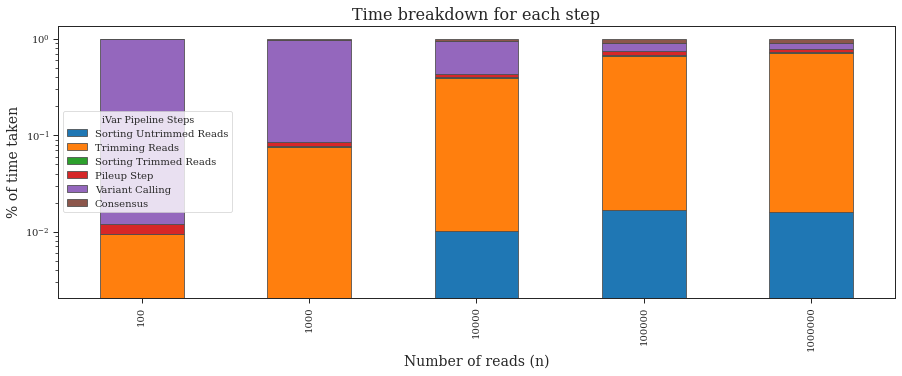

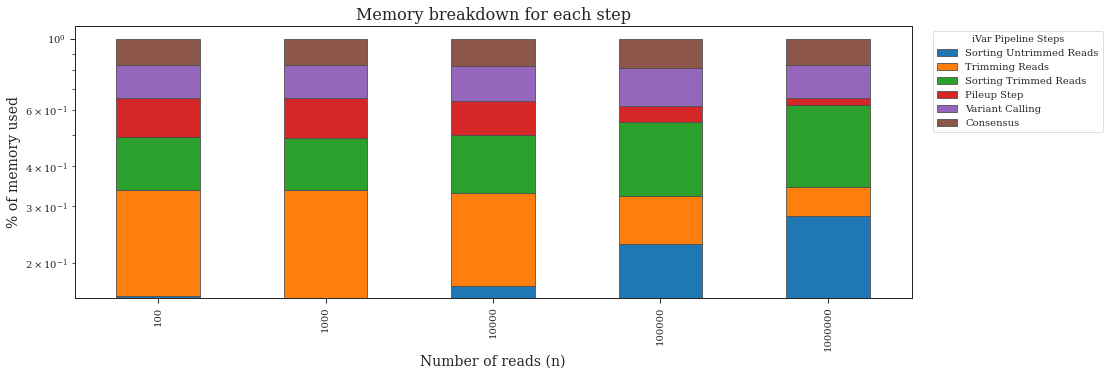

In [53]:
# charts that show total time taken and total memory used as a PROPORTION of total time/memory
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

labels = [100,1000,10000,100000,1000000]
steps = meta['steps']['ivar_pipeline']
human_readable_steps = meta['human_readable_steps']['ivar_pipeline']

timeTakenData = []
for n in labels:
	timeTaken = [sum([data[n][r][meta['time_fn'][step]]['time'] for r in range(1,10)])/10 for step in steps]
	totalTime = sum(timeTaken)
	timeTakenData.append([str(n)] + [time / totalTime for time in timeTaken])

df = pd.DataFrame(timeTakenData,
columns=["Steps"] + human_readable_steps)

time_chart = df.plot(x='Steps', kind='bar', stacked=True,
        title='Time breakdown for each step', figsize=(15,5))
time_chart.set_ylabel("% of time taken")
time_chart.set_xlabel("Number of reads (n)")
time_chart.axes.legend(title="iVar Pipeline Steps")
time_chart.set_yscale('log')

memoryUsedData = []

for n in labels:

	memoryUsed = [(sum([data[n][r][meta['time_fn'][step]]['mem'] for r in range(1,10)])/10) for step in steps]

	totalMemory = sum(memoryUsed)
	memoryUsedData.append([str(n)] + [memory / totalMemory for memory in memoryUsed])

df = pd.DataFrame(memoryUsedData,
columns=["Steps"] + human_readable_steps)

mem_chart = df.plot(x='Steps', kind='bar', stacked=True,
        title='Memory breakdown for each step', figsize=(15,5))
mem_chart.set_ylabel("% of memory used")
mem_chart.set_xlabel("Number of reads (n)")
mem_chart.axes.legend(title="iVar Pipeline Steps", bbox_to_anchor=(1.02,1))
mem_chart.set_yscale('log')


# save figures
time_chart.get_figure().savefig('%s/%s.png' % (FIGDIR, 'time_proportion'), format='png', bbox_inches='tight')
mem_chart.get_figure().savefig('%s/%s.png' % (FIGDIR, 'mem_proportion'), format='png', bbox_inches='tight')
time_chart.get_figure().savefig('%s/%s.pdf' % (FIGDIR, 'time_proportion'), format='pdf', bbox_inches='tight')
mem_chart.get_figure().savefig('%s/%s.pdf' % (FIGDIR, 'mem_proportion'), format='pdf', bbox_inches='tight')



[]


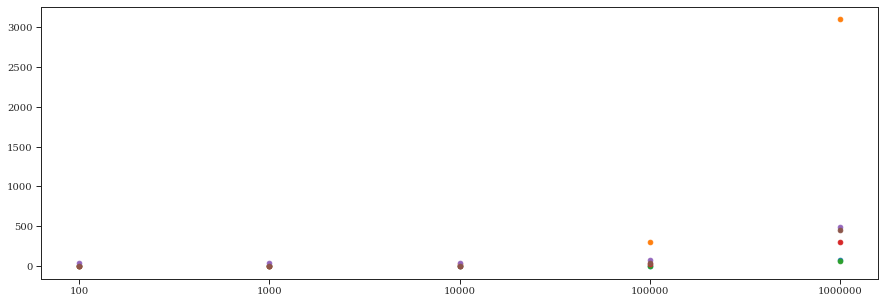

In [32]:
# investigating the Big-O of each step
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

labels = [100,1000,10000,100000,1000000]
steps = meta['steps']['ivar_pipeline']
human_readable_steps = meta['human_readable_steps']['ivar_pipeline']

timeTakenData = []
plt.figure(figsize=(15,5))
for i,step in enumerate(steps):
	timeTakenForEachN = [sum([data[n][r][meta['time_fn'][step]]['time'] for r in range(1,10)]) for n in labels]
	plt.scatter([str(label) for label in labels], timeTakenForEachN, label=human_readable_steps[i])

print(timeTakenData)
df = pd.DataFrame(timeTakenData,
columns=["Steps"] + human_readable_steps)

# Overall Time + Memory For Each Step for n = 1000000 (highest sample case tested)

[7.1129999999999995, 310.13, 6.487, 30.090000000000003, 48.894999999999996, 45.286]


"\nRuntime by Pipeline Step\nThis chart gives us an up close look at the runtime of iVar at 1000000 reads, helping us understand the runtime taken by each \nindividual step. From the data, it's apparent that the trimming reads section of the pipeline is the key bottleneck, taking\nup most of the time.\n\nMemory Usage by Pipeline Step\nThis chart gives us an up close look at the memory usage of iVar at 1000000 reads, helping us understand the memory usage taken by each \nindividual step. From the data, it's apparent that sorting reads generally takes up most of the memory, although variant calling and \nconsensus also use a good amount of memory.\n\n"

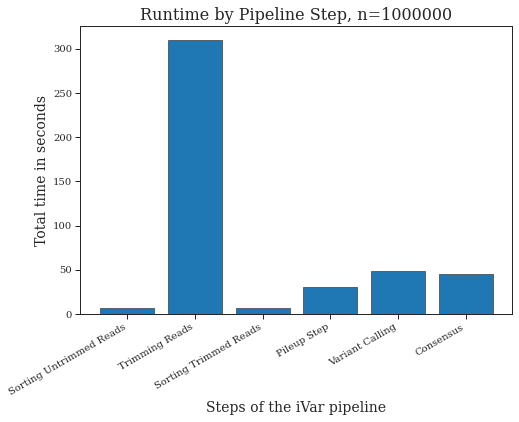

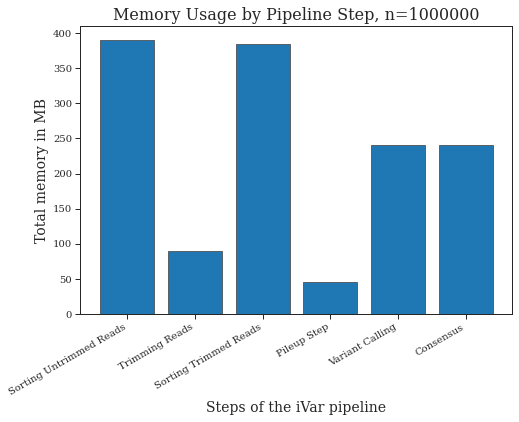

In [12]:

import numpy as np
steps = meta['steps']['ivar_pipeline']
human_readable_steps = meta['human_readable_steps']['ivar_pipeline']
n = 1000000

# get the average of all trials for n = 1000000
results_time = [sum([data[n][r][meta['time_fn'][step]]['time'] for r in range(1,10)])/10 for step in steps]

time_plot = plt.figure()
time_ax = time_plot.add_axes([0,0,1,1])
time_ax.set_title("Runtime by Pipeline Step, n=1000000")
time_ax.set_xlabel("Steps of the iVar pipeline")
time_ax.set_ylabel("Total time in seconds")
plt.setp(time_ax.get_xticklabels(), rotation=30, ha='right')
time_ax.bar(human_readable_steps, results_time)
print(results_time)

# get the average of all trials for n = 100
results_mem = [sum([data[n][r][meta['time_fn'][step]]['mem'] for r in range(1,10)])/10 for step in steps]
mem_plot = plt.figure()
mem_ax = mem_plot.add_axes([0,0,1,1])
mem_ax.set_title("Memory Usage by Pipeline Step, n=1000000")
mem_ax.set_xlabel("Steps of the iVar pipeline")
mem_ax.set_ylabel("Total memory in MB")
plt.setp(mem_ax.get_xticklabels(), rotation=30, ha='right')
mem_ax.bar(human_readable_steps, results_mem)

# save figures
time_plot.savefig('%s/%s.png' % (FIGDIR, 'total_time_pipeline'), format='png', bbox_inches='tight')
mem_plot.savefig('%s/%s.png' % (FIGDIR, 'total_mem_pipeline'), format='png', bbox_inches='tight')
time_plot.savefig('%s/%s.pdf' % (FIGDIR, 'total_time_pipeline'), format='pdf', bbox_inches='tight')
mem_plot.savefig('%s/%s.pdf' % (FIGDIR, 'total_mem_pipeline'), format='pdf', bbox_inches='tight')

"""
Runtime by Pipeline Step
This chart gives us an up close look at the runtime of iVar at 1000000 reads, helping us understand the runtime taken by each 
individual step. From the data, it's apparent that the trimming reads section of the pipeline is the key bottleneck, taking
up most of the time.

Memory Usage by Pipeline Step
This chart gives us an up close look at the memory usage of iVar at 1000000 reads, helping us understand the memory usage taken by each 
individual step. From the data, it's apparent that sorting reads generally takes up most of the memory, although variant calling and 
consensus also use a good amount of memory.

"""



### Plot Pipeline Runtime and Peak Memory vs. *n*

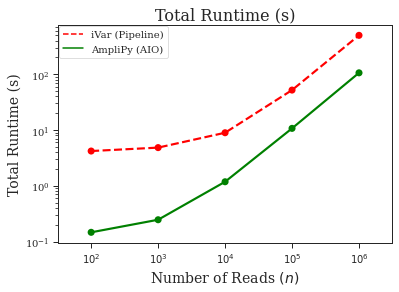

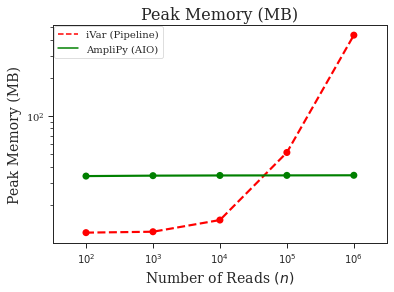

In [8]:
for plot in ['time', 'mem']:
    fig, ax = plt.subplots(); handles = list()
    for pipeline in ['ivar_pipeline', 'amplipy_aio']:
        handles.append(Line2D([0],[0],color=meta['color'][pipeline],label=meta['label'][pipeline],linewidth=1.5,linestyle=meta['linestyle'][pipeline]))
        x = list(); y = list()
        for n in sorted(data.keys()):
            for r in sorted(data[n].keys()):
                x.append(sci_not_mult10(n))
                if plot == 'time':
                    y.append(sum(data[n][r][meta['time_fn'][step]][plot] for step in meta['steps'][pipeline]))
                elif plot == 'mem':
                    y.append(max(data[n][r][meta['time_fn'][step]][plot] for step in meta['steps'][pipeline]))
        pointplot(x=x, y=y, color=meta['color'][pipeline], linestyles=meta['linestyle'][pipeline])
    plt.xlabel(r'Number of Reads $\left(n\right)$')
    plt.ylabel(meta['label'][plot])
    plt.title(meta['label'][plot])
    ax.set_yscale('log')
    plt.legend(handles=handles,bbox_to_anchor=(0.005, 0.995), loc=2, borderaxespad=0., frameon=True)
    fig.savefig('%s/%s.pdf' % (FIGDIR, plot), format='pdf', bbox_inches='tight')

### Plot iVar/Amplipy Ratio vs. *n*

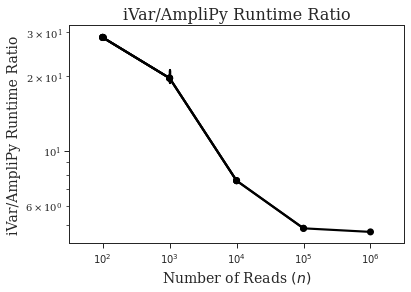

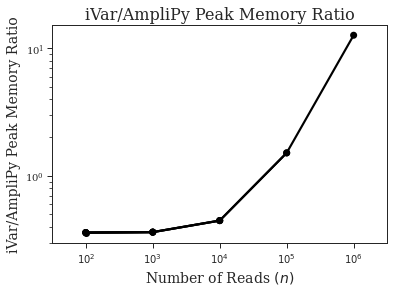

In [9]:
for plot in ['time', 'mem']:
    fig, ax = plt.subplots(); handles = list()
    #for pipeline in ['ivar_pipeline', 'amplipy_aio']:
    x = list(); y = list()
    for n in sorted(data.keys()):
        for r in sorted(data[n].keys()):
            x.append(sci_not_mult10(n))
            if plot == 'time':
                y_a = sum(data[n][r][meta['time_fn'][step]][plot] for step in meta['steps']['amplipy_aio'])
                y_i = sum(data[n][r][meta['time_fn'][step]][plot] for step in meta['steps']['ivar_pipeline'])
            elif plot == 'mem':
                y_a = max(data[n][r][meta['time_fn'][step]][plot] for step in meta['steps']['amplipy_aio'])
                y_i = max(data[n][r][meta['time_fn'][step]][plot] for step in meta['steps']['ivar_pipeline'])
            y.append(y_i/y_a)
        pointplot(x=x, y=y, color=meta['color']['ratio'], linestyles=meta['linestyle']['ratio'])
    plt.xlabel(r'Number of Reads $\left(n\right)$')
    plt.ylabel(meta['label']['ratio_%s' % plot])
    plt.title(meta['label']['ratio_%s' % plot])
    ax.set_yscale('log')
    fig.savefig('%s/%s.ratio.pdf' % (FIGDIR, plot), format='pdf', bbox_inches='tight')